In [3]:
"""
Read the data and convert it from ACQ4 to NWB format
"""
from collections import OrderedDict
import ephysanalysis as EP
import numpy as np
from pathlib import Path
import datetime
import time
from dateutil.tz import tzlocal
AR = EP.acq4read.Acq4Read()
from ephysanalysis import MatdatacRead as MDR
import pynwb as NWB

/Users/pbmanis/Desktop/Python/ephysanalysis/ephysanalysis/metaarray/MetaArray.py:36: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel


In [33]:
def makename(f):
    """
    Convert a name of this format:
     f = Path('/Volumes/Pegasus/ManisLab_Data3/Kasten_Michael/NF107Ai32Het/2017.05.01_000/slice_000/cell_000/CCIV_short_000')
    To:
    2017.05.01~S0C0~CCIV_short_000
    """
    protocol = f.stem
    cellp = f.parent
    cell = cellp.stem
    slicenp = cellp.parent
    slicen = slicenp.stem
    day = slicenp.parent
    foname = str(Path(day.name[:10], 'S'+slicen[-1]+'C'+cell[-1], protocol)).replace('/', '~')
    return foname

In [69]:

datapaths = {'basepath1': '/Volumes/Pegasus/ManisLab_Data3/Ben'}
opath = Path(datapaths['basepath1'], 'NWBFiles')

for f in Path(datapaths['basepath1']).glob('**'):
    if f.name.startswith('Duals'):
        print(f)
        acq4tonwb(f, opath)
#     dxkeys = list(dx.keys())


/Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_000
datafile:  /Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_000 True
Out file:  2019.09.30~S1C0~Duals_000
odict_keys(['__timestamp__', 'dirType', 'device 1', 'location 1', 'type 1', 'type 2', 'notes'])
room temp F P90+
writing to: /Volumes/Pegasus/ManisLab_Data3/Ben/NWBFiles/2019.09.30~S1C0~Duals_000.nwb
/Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_001
datafile:  /Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_001 True
Out file:  2019.09.30~S1C0~Duals_001
odict_keys(['__timestamp__', 'dirType', 'device 1', 'location 1', 'type 1', 'type 2', 'notes'])
room temp F P90+
writing to: /Volumes/Pegasus/ManisLab_Data3/Ben/NWBFiles/2019.09.30~S1C0~Duals_001.nwb
/Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_CC_000
datafile:  /Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_CC_0

In [68]:
def acq4tonwb(protocolname, outfilename):
    print('datafile: ', protocolname, protocolname.is_dir())
    outfilename = makename(protocolname)
    print('Out file: ', outfilename)

    AR.setProtocol(protocolname)
    AR.setDataName('MultiClamp1.ma')
    dataok = AR.getData()
    sample_rate = AR.sample_rate
    data_array = AR.data_array
    cmd_wave = AR.cmd_wave
    if not dataok:
        return
    info = AR.readDirIndex(currdir=protocolname.parent.parent.parent)['.']
    slice_index = AR.readDirIndex(currdir=protocolname.parent.parent)['.']
    cell_index = AR.readDirIndex(currdir=protocolname.parent)['.']
    proto_index = AR.readDirIndex(currdir=protocolname)['.']


    print(cell_index.keys())
#     print(proto_index)
    print(info['temperature'], info['sex'], info['age'])

    #
    # data in AR.data_array, AR.time_base, stimuli in AR.cmd_wave
    data_date = datetime.date.fromtimestamp(info['__timestamp__'])
    age = int(info['age'].replace('p', '').replace('P', '').replace('~', '').replace('+', ''))
    dob = datetime.datetime.combine(data_date - datetime.timedelta(days=age), datetime.time())
    dobstr = dob.strftime('%d/%m/%Y')
    subject = NWB.file.Subject(age=info['age'], 
            description=None, genotype='None', sex=info['sex'].upper(), species='Rat', 
            subject_id=None, weight=info['weight'], date_of_birth=dob)

#     print(info)
    if 'type 1' not in list(cell_index.keys()):
        ctypes = "unknown"
    else:
        ctypes = f"{cell_index['type 1']:s} and {cell_index['type 2']:s}" 
    nwbfile = NWB.NWBFile('Dual Recordings', str(protocolname), datetime.datetime.now(tzlocal()),
                  experimenter='Hughes, Ben; Kasten, Michael',
                  lab='Manis Lab',
                  institution='UNC Chapel Hill',
                  experiment_description='mPFC Pairs',
                  session_id=f"{0:d}",
                  notes=f"Cell Type: {ctypes:s} Protocol: {str(protocolname):s}",
                  subject=subject)
    device = NWB.device.Device('MC700A', parent=None)
    nwbfile.add_device(device)
    elec = NWB.icephys.IntracellularElectrode(name="elec0",
                                   description='KG33 patch as intracellular electrode',
                                   device=device)
    nwbfile.add_ic_electrode(elec)  # not well documented!

    istim1 = NWB.icephys.CurrentClampStimulusSeries( name="Ics1", data=np.array(AR.cmd_wave), unit='A',
            starting_time=info['__timestamp__'], rate=sample_rate[0],
            electrode=elec, gain=1.0, sweep_number=1)

    vdata1 = NWB.icephys.CurrentClampSeries('Vcs1', data=AR.data_array, 
        unit='V', electrode=elec, gain=1.0, bias_current=0.0, bridge_balance=0., 
        capacitance_compensation=0., stimulus_description='NA', 
        resolution=0.0, conversion=1.0, timestamps=None, 
        starting_time=info['__timestamp__'], rate=AR.sample_rate[0], 
        comments='no comments', description='no description', 
        control=None, control_description=None, sweep_number=1, parent=None)

    AR.setDataName('MultiClamp2.ma')
    dataok = AR.getData()
    vdata2 = NWB.icephys.CurrentClampSeries('Vcs2', data=AR.data_array, 
        unit='V', electrode=elec, gain=1.0, bias_current=0.0, bridge_balance=0., 
        capacitance_compensation=0., stimulus_description='NA', 
        resolution=0.0, conversion=1.0, timestamps=None, 
        starting_time=info['__timestamp__'], rate=AR.sample_rate[0], 
        comments='no comments', description='no description', 
        control=None, control_description=None, sweep_number=1, parent=None)
    istim2 = NWB.icephys.CurrentClampStimulusSeries( name="Ics2", data=np.array(AR.cmd_wave), unit='A',
            starting_time=info['__timestamp__'], rate=AR.sample_rate[0],
            electrode=elec, gain=1.0, sweep_number=1)


    nwbfile.add_acquisition(istim1)
    nwbfile.add_acquisition(vdata1)
    nwbfile.add_acquisition(istim2)
    nwbfile.add_acquisition(vdata2)

    outfile = Path(opath, outfilename)
    print(f"writing to: {str(outfile)+'.nwb':s}")
    with NWB.NWBHDF5IO(str(outfile)+'.nwb', 'w') as io:
        io.write(nwbfile)


In [71]:
io =  NWB.NWBHDF5IO('/Volumes/Pegasus/ManisLab_Data3/Ben/NWBFiles/2019.09.30~S1C0~Duals_000.nwb', 'r')
nwbfile = io.read()
print(nwbfile.fields['subject'])
print(nwbfile.fields['notes'])
vcs1 = nwbfile.get_acquisition('Vcs1')
ics1 = nwbfile.get_acquisition('Ics1')
vcs2 = nwbfile.get_acquisition('Vcs2')
ics2 = nwbfile.get_acquisition('Ics2')


subject <class 'pynwb.file.Subject'>
Fields:
  age: P90+
  date_of_birth: 2019-07-02 00:00:00-04:00
  genotype: None
  sex: F
  species: Rat
  weight: 

Cell Type: unknown and previous Protocol: /Volumes/Pegasus/ManisLab_Data3/Ben/2019.09.30_000/slice_001/pair_000/Duals_000


t1:  (120000,)
vcs1:  (20, 120000)


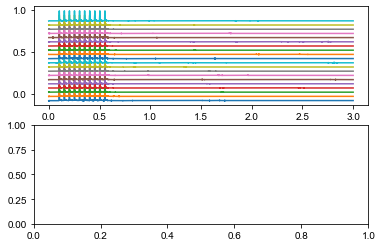

In [78]:
import matplotlib.pylab as mpl
f, ax = mpl.subplots(2,1)
# print(vcs1.rate)
# print(vcs1.data)
t1 = np.linspace(0., (1./vcs1.rate)*vcs1.data.shape[1], vcs1.data.shape[1])
# t1 = np.tile(t, (vcs1.data.shape[0], 1)).T
print('t1: ', t1.shape)
d  = np.array(vcs1.data)
print('vcs1: ', d.shape)
for i, di in enumerate(d):
    ax[0].plot(t1, di + 0.050*i)
# ax[1].plot(t, np.array(ics.data).T*1e9)  # make scale in nA

mpl.show()